In [1]:
# 0. Settings
!pip install laion-clap
!pip install torch
!pip install torchvision
!pip install torchaudio
import laion_clap
import glob
import json
import torch
import numpy as np
import torchaudio
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [8]:
# 1. labels/audio/text files path  

# # a file
# class_index_dict_path = 'data/test1/genre.json' 
# audio_files_path = 'data/test1/ss1.wav' # 'data/ESC50_1/test/**/*.wav'
# json_files_path = 'data/test1/ss1.json' # 'data/ESC50_1/test/**/*.json'
# column_name = 'genre' # 'genre', 'artist'

# files
class_index_dict_path = 'data/ESC50_class_labels_indices_space.json'
zip_files_path = 'data/0.tar'
unzip_files_folder_path = 'data/ESC50_1/test/'
upzip_audio_files_path = 'data/ESC50_1/test/**/*.flac'
upzip_text_files_path = 'data/ESC50_1/test/**/*.json'
column_name = 'tag' # 'genre', 'artist'


In [10]:
# 2. Pretrained Model calling
model = laion_clap.CLAP_Module(enable_fusion=True)
model.load_ckpt()

# # a file    
# class_index_dict = {v: k for v, k in json.load(open(class_index_dict_path)).items()}
# audio_files = sorted(glob.glob(audio_files_path, recursive=True))
# json_files = sorted(glob.glob(json_files_path, recursive=True)) 
# ground_truth_idx = [class_index_dict[json.load(open(jf))[column_name]] for jf in json_files]

# files
with tarfile.open(zip_files_path) as tar:
    tar.extractall(unzip_files_folder_path)
class_index_dict = {v: k for v, k in json.load(open(class_index_dict_path)).items()}
audio_files = sorted(glob.glob(upzip_audio_files_path, recursive=True))
json_files = sorted(glob.glob(upzip_text_files_path, recursive=True)) 
ground_truth_idx = [class_index_dict[json.load(open(jf))[column_name][0]] for jf in json_files]


print('='*50)
print(class_index_dict)
print('audio files 갯수:',len(audio_files))
print('json_files 갯수:',len(json_files))
print('ground_truth_idx 갯수:',len(ground_truth_idx))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.patch_embed.mel_conv2d.weight 	 Loaded
audio_branch.patch_embed.mel_conv2d.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.3.weight 	 Loaded
audio_branc

{'dog': 0, 'rooster': 1, 'pig': 2, 'cow': 3, 'frog': 4, 'cat': 5, 'hen': 6, 'insects': 7, 'sheep': 8, 'crow': 9, 'rain': 10, 'sea waves': 11, 'crackling fire': 12, 'crickets': 13, 'chirping birds': 14, 'water drops': 15, 'wind': 16, 'pouring water': 17, 'toilet flush': 18, 'thunderstorm': 19, 'crying baby': 20, 'sneezing': 21, 'clapping': 22, 'breathing': 23, 'coughing': 24, 'footsteps': 25, 'laughing': 26, 'brushing teeth': 27, 'snoring': 28, 'drinking sipping': 29, 'door wood knock': 30, 'mouse click': 31, 'keyboard typing': 32, 'door wood creaks': 33, 'can opening': 34, 'washing machine': 35, 'vacuum cleaner': 36, 'clock alarm': 37, 'clock tick': 38, 'glass breaking': 39, 'helicopter': 40, 'chainsaw': 41, 'siren': 42, 'car horn': 43, 'engine': 44, 'train': 45, 'church bells': 46, 'airplane': 47, 'fireworks': 48, 'hand saw': 49}
audio files 갯수: 400
json_files 갯수: 400
ground_truth_idx 갯수: 400


In [11]:
# 3. Zero-shot processing
with torch.no_grad():
    ground_truth = torch.tensor(ground_truth_idx).view(-1, 1)
    # Get text features
    all_texts = ["This song is " + t for t in class_index_dict.keys()]
    text_embed = model.get_text_embedding(all_texts)
    audio_embed = model.get_audio_embedding_from_filelist(x=audio_files) 
    print('text_embed shape :',text_embed.shape)
    print('audio_embed shape :',audio_embed.shape)
    ranking = torch.argsort(torch.tensor(audio_embed) 
                            @ torch.tensor(text_embed).t(), 
                            descending=True)
    preds = torch.where(ranking == ground_truth)[1]
    preds_text=preds
    preds = preds.cpu().numpy()
    metrics = {}
    metrics[f"mean_rank"] = preds.mean() + 1
    metrics[f"median_rank"] = np.floor(np.median(preds)) + 1
    for k in [1, 5, 10]:
        metrics[f"R@{k}"] = np.mean(preds < k)
    # map@10
    metrics[f"mAP@10"] = np.mean(np.where(preds < 10, 1 / (preds + 1), 0.0))
    print("="*50)
    print("Zeroshot Classification Results:")
    for k, v in metrics.items():
        print(f"{k}: {round(v, 4):.4f}")

text_embed shape : (50, 512)
audio_embed shape : (400, 512)
Zeroshot Classification Results:
mean_rank: 2.4975
median_rank: 1.0000
R@1: 0.7125
R@5: 0.9025
R@10: 0.9500
mAP@10: 0.7926


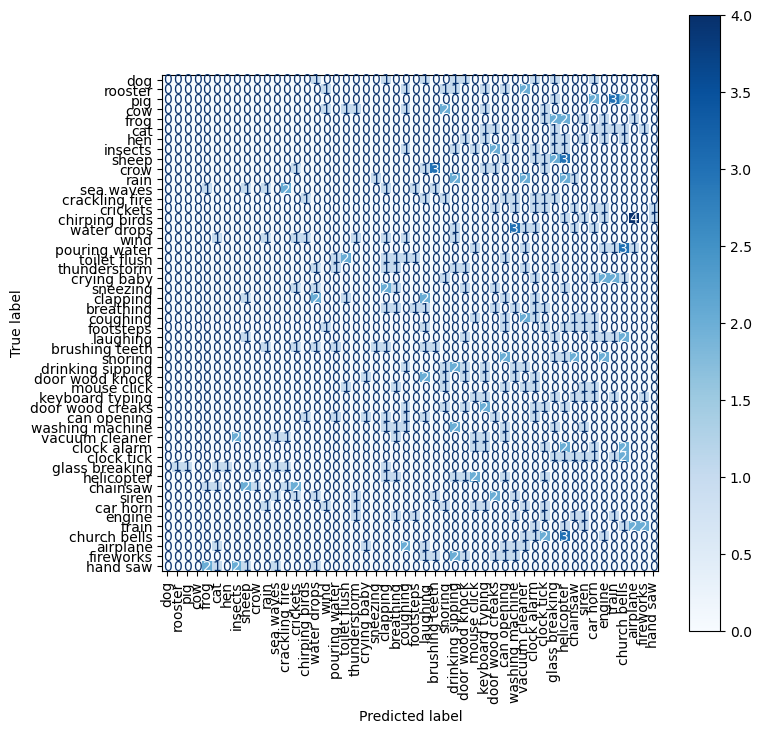

In [12]:
# 4. Visualizing
def confusion_matrix(y_true, y_pred, num_classes):
    conf_mat = np.zeros((num_classes, num_classes))
    for i in range(len(y_true)):
        true_idx = y_true[i]
        pred_idx = y_pred[i]
        conf_mat[true_idx][pred_idx] += 1
    return conf_mat

def plot_confusion_matrix(conf_mat, class_names):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation=90)  # x축 레이블을 90도 기울임
    plt.show()

num_classes = len(class_index_dict)
conf_mat = confusion_matrix(ground_truth, torch.argmax(ranking, dim=1), num_classes)
class_names = list(class_index_dict.keys())
plot_confusion_matrix(conf_mat, class_names)